In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [85]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [86]:
data = pd.read_csv('./dataset/cleaned_merged_dataset.csv')

In [87]:
mask = (data.Nature_Code != 'Military')
data = data[mask]
mask = (data.Year > 1960)
data = data[mask]

In [88]:
data.columns

Index(['Engines', 'Narrative', 'FlightNumber', 'AirplaneDamage', 'Phase',
       'DestinationAirport', 'Date', 'Time', 'DepartureAirport', 'Operator',
       'AirplaneFate', 'FirstFlight', 'Nature_Code', 'Type_Code',
       'Engine_Type', 'Engine_count', 'Crew_Fatal', 'Crew_Occ', 'Total_Fatal',
       'Total_Occ', 'Psngr_Fatal', 'Psngr_Occ', 'GndFatal', 'Coll_Fatal',
       'Crash_Elev_m', 'Day', 'Month', 'Year', 'Dep_Airport_1',
       'Dest_Airport_1', 'Age', 'Country', 'latlon', 'sub_place', 'Continents',
       'Hemisphere', 'Seasons', 'orig_latitude', 'orig_longitude', 'Decade'],
      dtype='object')

In [89]:
data_aus = data[data['Continents'] == 'Australia']

In [90]:
data_aus.shape

(145, 40)

In [91]:
data_aus = data_aus[['Year', 'Month', 'Date', 'Time']]

In [92]:
data = data_aus[:]

In [93]:
## Code for converting to time series
data['Month'] = [datetime.strptime(m, '%b').month for m in data['Month']]

data.ix[data['Time'] == '24:00', 'Time'] = '23:59'

time = []
for t in data['Time']:
    if 'ca.' in t:
        t = t[4:9]
    elif 'c' in t:
        t = t[2:7]
    elif len(t) != 5:
        t = t[0:5]
    else:
        pass
    time.append(t)
data['Time'] = time

data['Hour'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_hour
                 for t in data['Time']]

data['Min'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_min
                 for t in data['Time']]

data.loc[(data['Date'] == 0) & (data['Month'] == 2), 'Date'] = 28

data.loc[(data['Date'] == 0) & 
         ((data['Month'] == 4) | (data['Month'] == 6) | (data['Month'] == 9) | (data['Month'] == 11)), 'Date'] = 30
data.loc[(data['Date'] == 0), 'Date'] = 31

data['DateTime'] = data[['Year', 'Month', 'Date', 'Hour', 'Min']].apply(lambda s : datetime(*s),axis = 1)
data.set_index('DateTime', inplace=True)
# data.index = pd.to_datetime(data.index)

In [94]:
data['Count'] = [1 for i in range(0, data.shape[0])]
data = data[['Count']]
data.head()

,Count
DateTime,
2017-02-21 08:59:00,1
2017-01-26 17:03:00,1
2000-06-15 14:00:00,1
2000-05-22 14:00:00,1
1999-06-17 08:52:00,1


In [95]:
data = data.resample('12M',how={'Count':'sum'})

In [96]:
data.head()

,Count
DateTime,
1961-04-30,1.0
1962-04-30,4.0
1963-04-30,NaN
1964-04-30,3.0
1965-04-30,3.0


In [98]:
data.fillna(0, inplace = True)

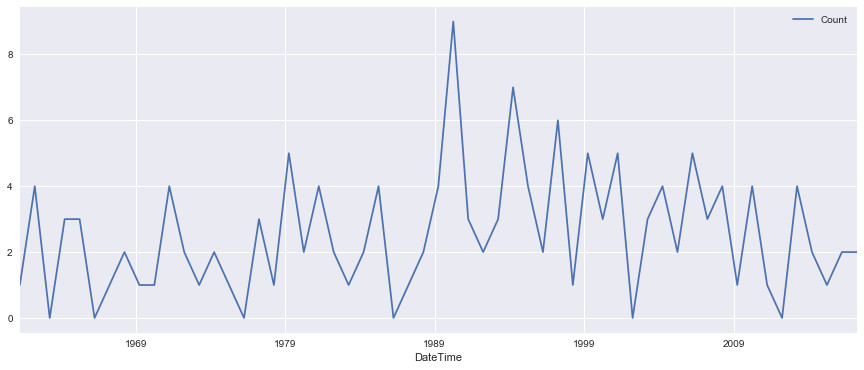

In [99]:
data.plot()

In [100]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 


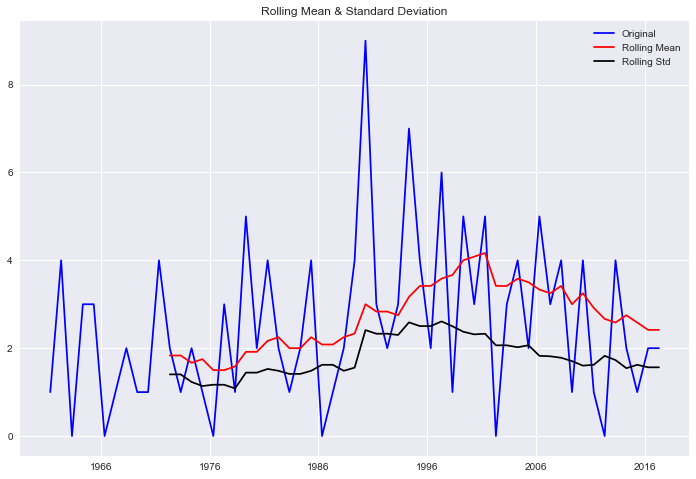

Results of Dickey-Fuller Test:
Test Statistic                -7.610254e+00
p-value                        2.265082e-11
#Lags Used                     0.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64


In [101]:
# perform test
test_stationarity(data.Count)

In [102]:
df = data.stack().values
model = sm.tsa.statespace.SARIMAX(df, order=(0,1,1), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                -113.992
Date:                           Sun, 28 May 2017   AIC                            233.985
Time:                                   13:51:33   BIC                            240.114
Sample:                                        0   HQIC                           236.367
                                            - 57                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8558      0.166     -5.161      0.000      -1.181      -0.531
ma.S.L4       -0.9993     44.287     -0.023

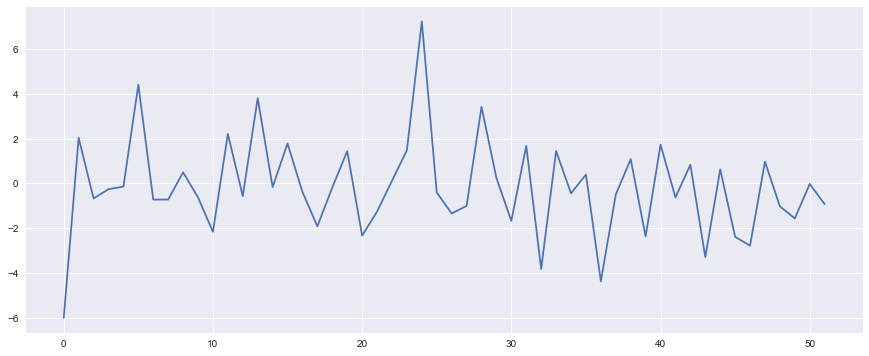

In [103]:
# Don't plot the first 5 values, to account for data loss when differencing (d=1 + D=5)
residuals = results.resid[5:]
plt.plot(residuals)

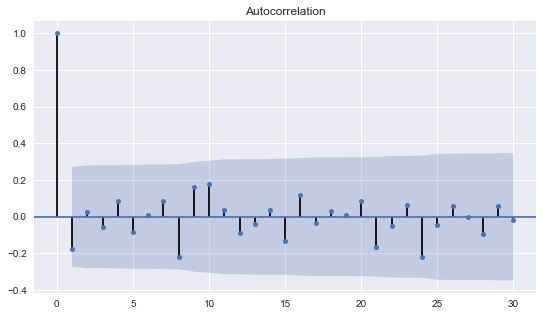

In [104]:
# Plot the ACF and PACF of the residuals.
fig, ax = plt.subplots(figsize=(9,5))
plot_acf(residuals, lags=30, ax=ax)
plt.show()

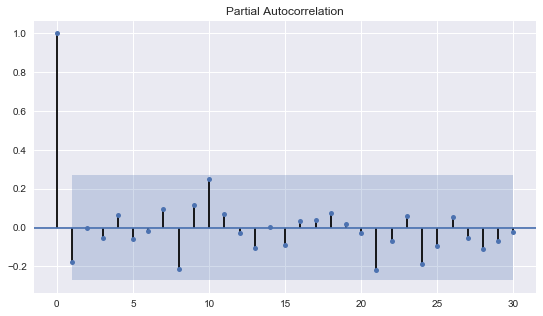

In [105]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(residuals, lags=30, ax=ax)
plt.show()

In [106]:
# Increase order of the sarimax model
model = sm.tsa.statespace.SARIMAX(df, order=(0,1,2), seasonal_order=(0,1,1,4))
results = model.fit()
print (results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   57
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                -113.365
Date:                           Sun, 28 May 2017   AIC                            234.730
Time:                                   13:51:40   BIC                            242.903
Sample:                                        0   HQIC                           237.906
                                            - 57                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9112      0.252     -3.610      0.000      -1.406      -0.416
ma.L2          0.0888      0.205      0.434

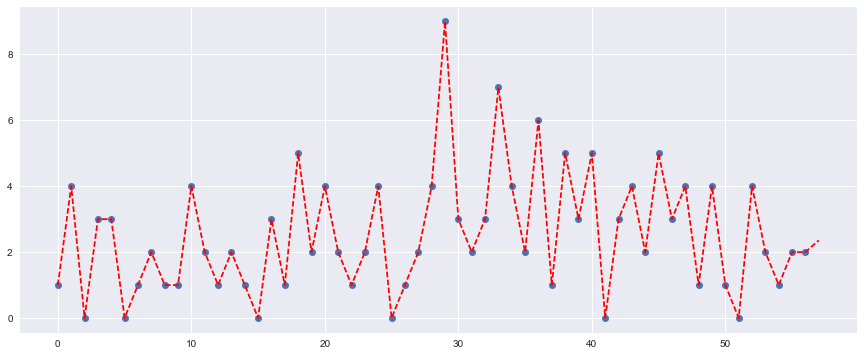

In [111]:
# forecasting
res = model.fit()
preds = res.forecast(1)
fcast = np.concatenate((df, preds), axis=0)

# plt.figure()
plt.plot(df, 'o' , fcast, 'r--')

In [112]:
import itertools

In [113]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [116]:
y = pd.Series(index = data.index, data = data.Count)

In [118]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:224.3296609950958
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1429.2974285849964
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:217.66867888583076
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:207.76670710102042
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:163.92915482284906
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1401.9644125330342
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:270.6559877409356
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:217.12151080814218
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:216.8390503729951
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1147.5280192103762
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:219.1267377307787
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:205.3781094485068
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:165.92862584424196
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1195.0825137891918
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:213.15281122720688
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1325.726068308685
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:217.4140826888729
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:214.96818114480638

In [119]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1490      0.273     -0.546      0.585      -0.684       0.386
ma.L1         -0.8185      0.232     -3.522      0.000      -1.274      -0.363
ar.S.L12      -0.5347      0.124     -4.321      0.000      -0.777      -0.292
sigma2         6.9337      1.460      4.748      0.000       4.072       9.796


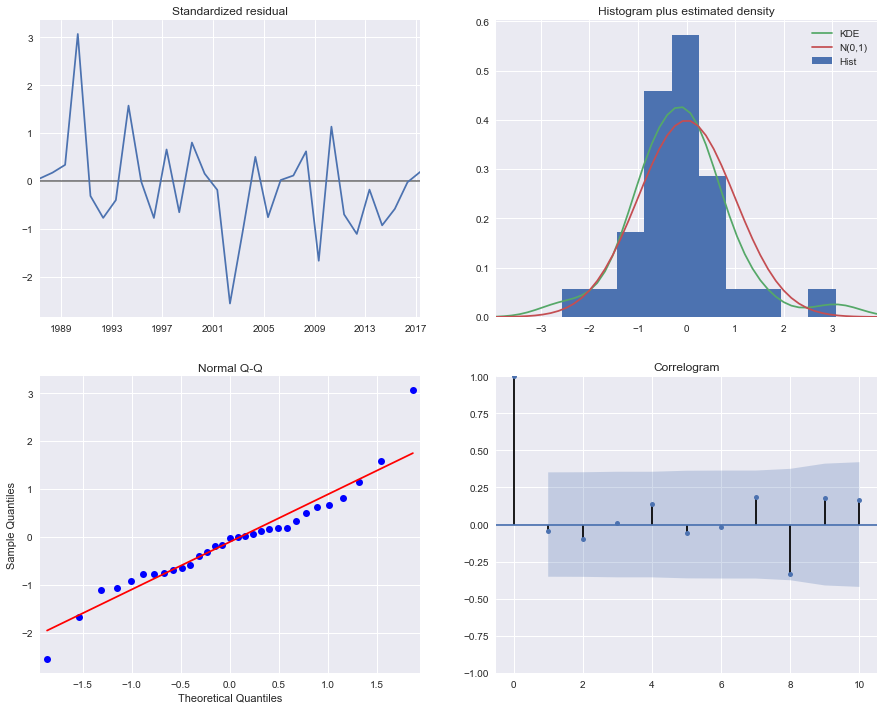

In [120]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [122]:
y

DateTime
1961-04-30    1.0
1962-04-30    4.0
1963-04-30    0.0
1964-04-30    3.0
1965-04-30    3.0
1966-04-30    0.0
1967-04-30    1.0
1968-04-30    2.0
1969-04-30    1.0
1970-04-30    1.0
1971-04-30    4.0
1972-04-30    2.0
1973-04-30    1.0
1974-04-30    2.0
1975-04-30    1.0
1976-04-30    0.0
1977-04-30    3.0
1978-04-30    1.0
1979-04-30    5.0
1980-04-30    2.0
1981-04-30    4.0
1982-04-30    2.0
1983-04-30    1.0
1984-04-30    2.0
1985-04-30    4.0
1986-04-30    0.0
1987-04-30    1.0
1988-04-30    2.0
1989-04-30    4.0
1990-04-30    9.0
1991-04-30    3.0
1992-04-30    2.0
1993-04-30    3.0
1994-04-30    7.0
1995-04-30    4.0
1996-04-30    2.0
1997-04-30    6.0
1998-04-30    1.0
1999-04-30    5.0
2000-04-30    3.0
2001-04-30    5.0
2002-04-30    0.0
2003-04-30    3.0
2004-04-30    4.0
2005-04-30    2.0
2006-04-30    5.0
2007-04-30    3.0
2008-04-30    4.0
2009-04-30    1.0
2010-04-30    4.0
2011-04-30    1.0
2012-04-30    0.0
2013-04-30    4.0
2014-04-30    2.0
2015-04-30    1.0
2

In [123]:
x = pd.to_datetime('2015-04-30')
pred = results.get_prediction(start=x, dynamic=True)
pred_ci = pred.conf_int()

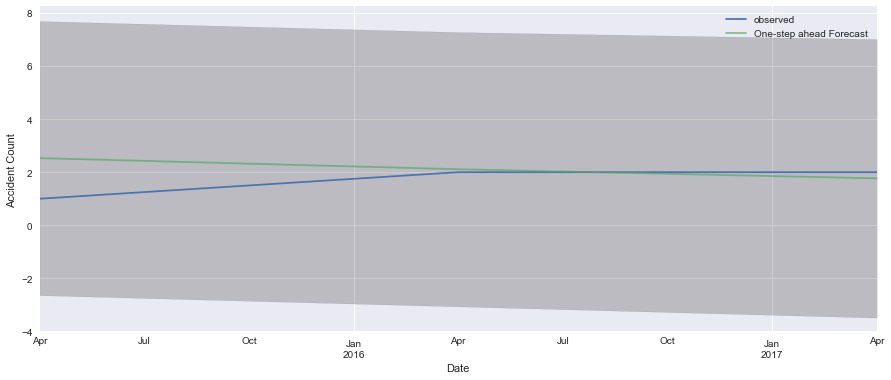

In [125]:
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')
plt.legend()

plt.show()

In [126]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-04-30':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.8


In [128]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-04-30'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

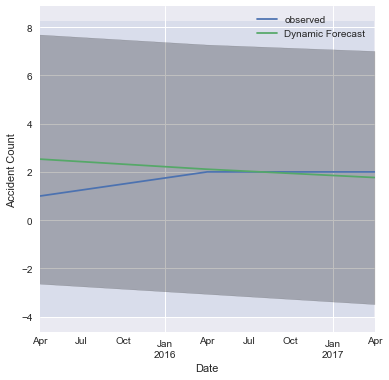

In [136]:
ax = y['2015':].plot(label='observed', figsize=(6, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-04-30'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')

plt.legend()
plt.show()

In [137]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2015-04-30':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.8


In [138]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2517-04-30 00:00:00